In [1]:
from mylib.statistic_test import *

code_id = '0818 - Segmented Neural Trajectory'
loc = os.path.join(figpath, 'Dsp', code_id)
mkdir(loc)

from mylib.dsp.neural_traj import visualize_neurotraj3d, visualize_neurotraj
with open(r"E:\Data\Dsp_maze\10224\20231015\trace.pkl", 'rb') as handle:
    trace = pickle.load(handle)

e:\Anaconda\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        E:\Data\FinalResults\Dsp\0818 - Segmented Neural Trajectory is already existed!


In [ ]:
for i in range(1, 7):
    save_loc = join(loc, f'Seg {i}')
    mkdir(save_loc)
    idx = np.where(trace['traj_segment_ids'] == i)[0]
    pos = trace['pos_traj'][idx]
    route_ids = trace['traj_route_ids'][idx]
    
    nodes = spike_nodes_transform(pos, nx=12).astype(np.float64)
    
    for i in range(pos.shape[0]):
        if nodes[i] not in CP_DSP[route_ids[i]]:
            nodes[i] = np.nan
            
    pos = cp.deepcopy(pos[np.isnan(nodes) == False])
    nodes = nodes[np.isnan(nodes) == False]
    
    nodes_reorder = np.zeros_like(nodes, dtype=np.int64)
    G = NRG[1]
    for j in range(nodes.shape[0]):
        nodes_reorder[j] = G[nodes[j]]
        
    vmin, vmax = np.min(nodes_reorder), np.max(nodes_reorder)
    colors = np.array(sns.color_palette("rainbow", vmax-vmin+1))
    x, y = (pos-1) % 48, (pos-1)//48
    x = x + np.random.rand(x.shape[0]) - 0.5
    y = y + np.random.rand(y.shape[0]) - 0.5

    fig = plt.figure(figsize=(3,3))
    ax = Clear_Axes(plt.axes())
    DrawMazeProfile(maze_type=1, axes=ax, nx=48, color='black', linewidth=.5)
    ax.scatter(
        x, 
        y, 
        s = 3, 
        color=colors[nodes_reorder.astype(np.int64) - vmin],
        alpha=0.5,
        linewidth = 0
    )
    ax.set_aspect('equal')
    ax.axis([-0.8, 47.8, 47.8, -0.8])
    plt.savefig(os.path.join(save_loc, f'behav.svg'), dpi = 600)
    plt.savefig(os.path.join(save_loc, f'behav.png'), dpi = 600)
    plt.show()

In [ ]:
seg = 6
save_loc = join(loc, f'Seg {seg}')
res = visualize_neurotraj(
    trace, 
    n_components=2, 
    component_i=0,
    component_j=1,
    is_show=True,
    save_dir=save_loc,
    segment=seg,
    palette='default',
    figsize = (4, 2),
    method="LDA",
    train_label = 'lap'
    #n_neighbors=30,
    #min_dist=0.05
)

Dimensional reduction with LDA - 6 components.
Visualizing neural trajectory - component 0, 1, 3.



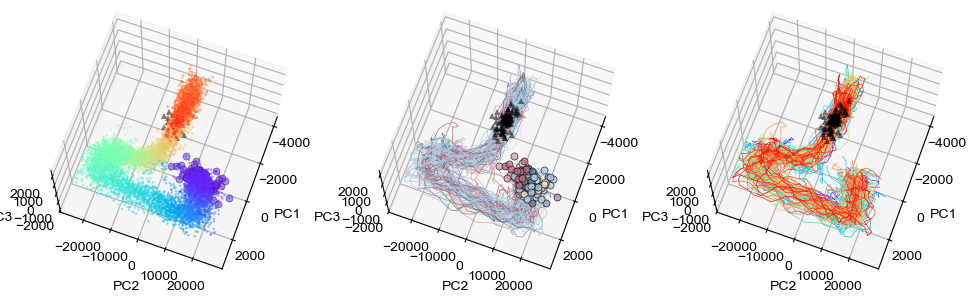

: 

In [3]:
seg = 6
save_loc = join(loc, f'Seg {seg}')
res = visualize_neurotraj3d(
    trace, 
    n_components=6, 
    component_i=0,
    component_j=1,
    component_k=3,
    is_show=True,
    save_dir=save_loc,
    segment=seg,
    palette='default',
    method="LDA",
    train_label = 'pos',
    pca_n=300,
    elev=70,
    azim=20
    #n_neighbors=30,
    #min_dist=0.05
)

In [ ]:
res['reduced_data'].shape, res['traj_lap_ids'].shape, res['traj_route_ids'].shape, res['traj_segment_ids'].shape

In [10]:
from mylib.dsp.neural_traj import calc_trajectory_similarity

D, laps, routes = calc_trajectory_similarity(
    res['reduced_data'],
    res['traj_lap_ids'],
    res['traj_route_ids'],
    dim = 6
)

100%|██████████| 96/96 [00:02<00:00, 47.41it/s]


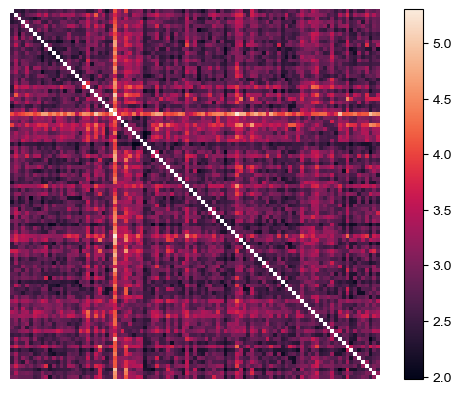

In [12]:
ax = Clear_Axes(plt.axes())
im = ax.imshow(D, cmap='rocket')
plt.colorbar(im)

In [15]:
if __name__ == '__main__':
    from mylib.dsp.neural_traj import preprocess_neural_traj, pca_dim_reduction, get_segmented_peakrate
    res = preprocess_neural_traj(
        trace, 
        segment=6,
        peak_thre=1
    )
    
    neural_traj = res['neural_traj']
    lap_ids = res['traj_lap_ids']
    route_ids = res['traj_route_ids']
    segment_traj = res['traj_segment_ids']
    pos_traj = res['pos_traj']
    pos_traj_reord = res['pos_traj_reord']
    ego_pos_traj = res['ego_pos_traj']

    # Computation Starts.
    seg = []
    route = []
    targ_route = []
    mean_trajectory_distance = []
    sub_space_type = []
    
    # LDA Dim reduction maximizing the separability of position.
    for i in range(1, 7):
        if i != 6:
            continue
        legal_route = np.intersect1d(
            CP_DSP[0], CP_DSP[i]
        )
        idx = np.where(
            (segment_traj == i) & (pos_traj_reord <= 111)
        )[0]
        
        """
        reduced_data_pca, pca = pca_dim_reduction(
            neural_traj[:, idx],
            n_components=30,
        )
        """
        reduced_data_pca = neural_traj[:, idx].T
        reduced_data, lda = lda_dim_reduction(
            reduced_data_pca.T,
            pos_traj[idx],#route_ids[idx],#pos_traj[idx],
            n_components=i,
    solver="eigen",
    shrinkage=0.05
        )

        W = lda.scalings_
        #W = pca.components_.T @ lda.scalings_
        
        mat, laps, routes = calc_trajectory_similarity(
            reduced_data=reduced_data,
            lap_ids=lap_ids[idx],
            route_ids=route_ids[idx],
            dim=6
        )       

100%|██████████| 96/96 [00:02<00:00, 39.05it/s]


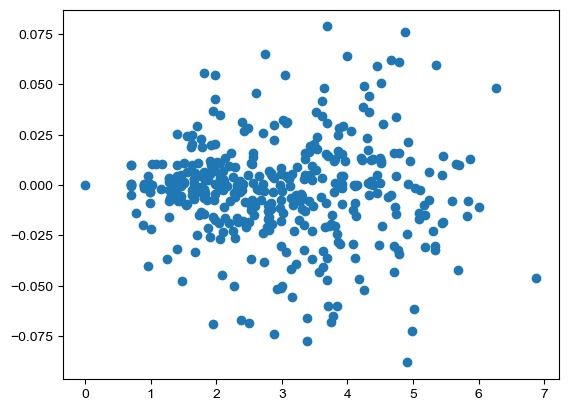

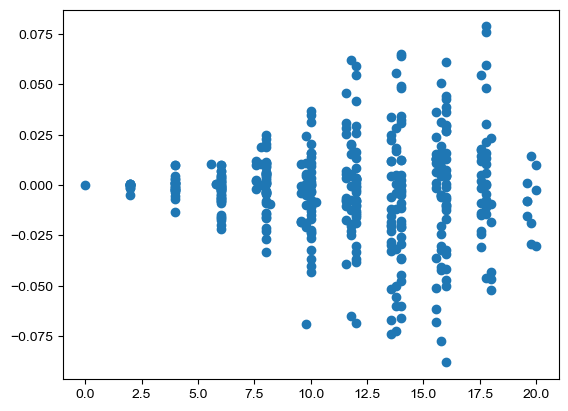

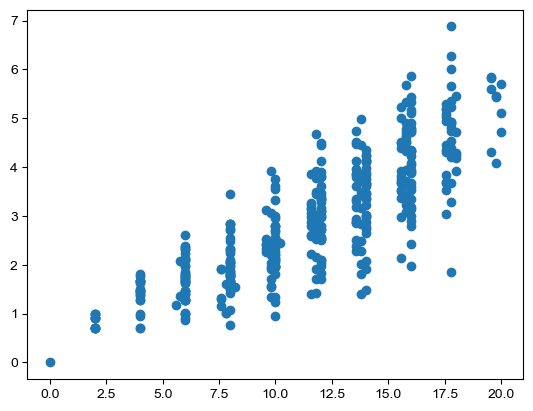

In [8]:
import seaborn as sns

seg_peak_rate = get_segmented_peakrate(trace)

peak_temp_rate = np.max(neural_traj[:, idx], axis=1)
std_temp_rate = np.std(neural_traj[:, idx], axis=1)

route_wise_std = np.zeros((neural_traj.shape[0], 7)) * np.nan
for i in range(7):
    aidx = np.where(
            (segment_traj == 6) & (pos_traj_reord <= 111) & (route_ids == i)
        )[0]
    if len(aidx) == 0:
        continue
    
    route_wise_std[:, i] = np.nanmax(neural_traj[:, aidx], axis=1)
    
route_wise_std = np.nanstd(route_wise_std, axis=1)

plt.plot(
    route_wise_std,
    W[:, 0],
    'o'
)
plt.show()
plt.plot(
    peak_temp_rate,
    W[:, 0],
    'o'
)
plt.show()
plt.plot(
    peak_temp_rate,
    route_wise_std,
    'o'
)

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5
 5 5 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0]


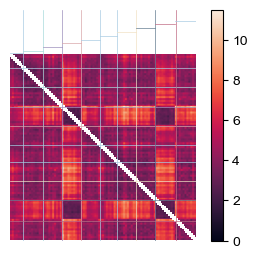

In [16]:
print(routes)
fig = plt.figure(figsize=(4,3))
ax = Clear_Axes(plt.axes())
im = ax.imshow(mat, cmap='rocket', vmin = 0)
ax.set_aspect('equal')

ax.plot([-0.5, 6.5], [-1.5, -1.5], linewidth=0.5, color=DSPPalette[0])
ax.axvline(6.5, linewidth=0.5, color=DSPPalette[0])
ax.axhline(6.5, linewidth=0.5, color=DSPPalette[0])

ax.plot([6.5, 16.5], [-2.5, -2.5], linewidth=0.5, color=DSPPalette[1])
ax.axvline(16.5, linewidth=0.5, color=DSPPalette[1])
ax.axhline(16.5, linewidth=0.5, color=DSPPalette[1])

ax.plot([16.5, 26.5], [-4.5, -4.5], linewidth=0.5, color=DSPPalette[2])
ax.axvline(26.5, linewidth=0.5, color=DSPPalette[2])
ax.axhline(26.5, linewidth=0.5, color=DSPPalette[2])

ax.plot([26.5, 36.5], [-6.5, -6.5], linewidth=0.5, color=DSPPalette[3])
ax.axvline(36.5, linewidth=0.5, color=DSPPalette[3])
ax.axhline(36.5, linewidth=0.5, color=DSPPalette[3])

ax.plot([36.5, 46.5], [-8.5, -8.5], linewidth=0.5, color=DSPPalette[0])
ax.axvline(46.5, linewidth=0.5, color=DSPPalette[0])
ax.axhline(46.5, linewidth=0.5, color=DSPPalette[0])

ax.plot([46.5, 55.5], [-10.5, -10.5], linewidth=0.5, color=DSPPalette[0])
ax.axvline(55.5, linewidth=0.5, color=DSPPalette[0])
ax.axhline(55.5, linewidth=0.5, color=DSPPalette[0])

ax.plot([55.5, 65.5], [-12.5, -12.5], linewidth=0.5, color=DSPPalette[4])
ax.axvline(65.5, linewidth=0.5, color=DSPPalette[4])
ax.axhline(65.5, linewidth=0.5, color=DSPPalette[4])

ax.plot([65.5, 75.5], [-14.5, -14.5], linewidth=0.5, color=DSPPalette[5])
ax.axvline(75.5, linewidth=0.5, color=DSPPalette[5])
ax.axhline(75.5, linewidth=0.5, color=DSPPalette[5])

ax.plot([75.5, 85.5], [-16.5, -16.5], linewidth=0.5, color=DSPPalette[6])
ax.axvline(86.5, linewidth=0.5, color=DSPPalette[6])
ax.axhline(86.5, linewidth=0.5, color=DSPPalette[6])

ax.plot([85.5, 96.5], [-18.5, -18.5], linewidth=0.5, color=DSPPalette[0])
ax.axvline(96.5, linewidth=0.5, color=DSPPalette[0])
ax.axhline(96.5, linewidth=0.5, color=DSPPalette[0])
plt.colorbar(im)
##plt.savefig(os.path.join(loc, 'Example Trajectory Distance [context_sensitive].png'), dpi=600)
#plt.savefig(os.path.join(loc, 'Example Trajectory Distance [context_sensitive].svg'), dpi=600) #[context_sensitive] 
